# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
time: 369 µs (started: 2023-02-24 14:49:29 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, 
    Dense, Dropout, Input, Concatenate, 
    GlobalAveragePooling2D
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.68 s (started: 2023-02-24 14:49:29 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'ResNet50'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__)
print()

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/regular_otsu/
versión Keras: 2.11.0

time: 1.12 ms (started: 2023-02-24 14:49:33 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 35.2 s (started: 2023-02-24 14:49:33 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG = regular o inverted

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):
    '''Crea un modelo de Deep Learning
    '''
    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_Resnet50_9G = keras.applications.ResNet50(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_Resnet50_9G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME):
    '''Guardar el modelo en disco duro.
    Debe especificarse la ruta porque por defecto la guarda
    en el la memoria de la misma instancia de Google Colab.
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG= regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME = Deep Neural Network's name like ResNet50 or DenseNet121
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_'\
                + TYPE_IMG +'__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/otsu_reg/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH)
    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 7.25 ms (started: 2023-02-24 14:50:10 +00:00)


# Imgs 64x64

- Test Accuracy: 0.3399493992328644
- Test Loss: 3.738039970397949
- time: 2h 7min 39s
- F1 score: 0.3324206191841957
- Precision score: 0.37818065177998383
- Recall:  0.3399494097807757
- Epoch: 50/50


## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/regular_otsu/
time: 1.45 ms (started: 2023-02-24 14:50:20 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 18.3 s (started: 2023-02-24 14:50:20 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.04 ms (started: 2023-02-24 14:50:39 +00:00)


## Preparar el modelo

In [11]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

94765736/94765736 [==============================] - 5s 0us/step
time: 11 s (started: 2023-02-24 14:50:39 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['concatenate[0][0]']            
                                                                                              

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 165s 11ms/step - loss: 7.5599 - sparse_categorical_accuracy: 0.0172 - val_loss: 7.2102 - val_sparse_categorical_accuracy: 0.0356
Epoch 2/50
13899/13899 [==============================] - 152s 11ms/step - loss: 6.9475 - sparse_categorical_accuracy: 0.0526 - val_loss: 6.7590 - val_sparse_categorical_accuracy: 0.0606
Epoch 3/50
13899/13899 [==============================] - 152s 11ms/step - loss: 6.5481 - sparse_categorical_accuracy: 0.0819 - val_loss: 6.4344 - val_sparse_categorical_accuracy: 0.0889
Epoch 4/50
13899/13899 [==============================] - 152s 11ms/step - loss: 6.2448 - sparse_categorical_accuracy: 0.1075 - val_loss: 6.1784 - val_sparse_categorical_accuracy: 0.1096
Epoch 5/50
13899/13899 [==============================] - 153s 11ms/step - loss: 5.9998 - sparse_categorical_accuracy: 0.1295 - val_loss: 5.9700 - val_sparse_categorical_accuracy: 0.1261
Epoch 6/50
13899/13899 [==============================] - 153s 11

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.83 s (started: 2023-02-24 16:58:30 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 16s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.3399493992328644
- Test Loss: 3.738039970397949
- time: 
- F1 score: 0.3324206191841957
- Precision score: 0.37818065177998383
- Recall:  0.3399494097807757
- Epoch: 
*********************************************************************************************************************************
time: 36.6 s (started: 2023-02-24 16:58:33 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Graficando

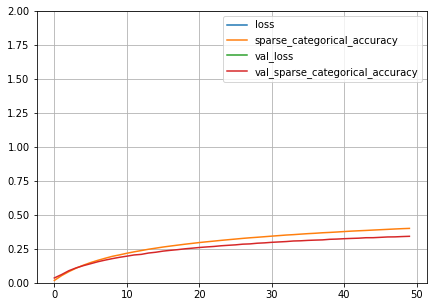

time: 226 ms (started: 2023-02-24 16:59:09 +00:00)


In [16]:
plot_loss(history)

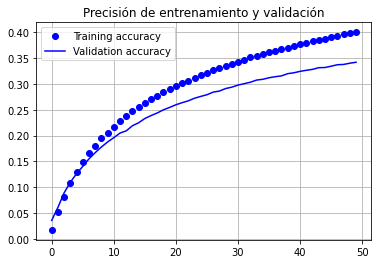

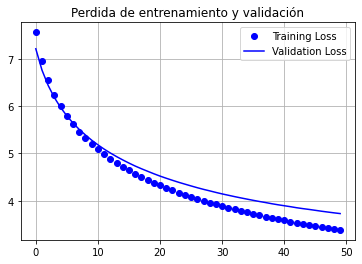

time: 253 ms (started: 2023-02-24 16:59:09 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl9_imgs64_regular__OTSU.h5
time: 3.37 s (started: 2023-02-24 16:59:10 +00:00)


# Imgs 96x96

- Test Accuracy: 0.4817369282245636
- Test Loss: 2.9426674842834473
- time: 2h 16min 34s
- F1 score: 0.47714890149499517
- Precision score: 0.5152299496167855
- Recall:  0.4817369308600337
- Epoch: 50/50


## Cargar las imágenes

In [19]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 892 µs (started: 2023-02-24 17:00:48 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 20.3 s (started: 2023-02-24 17:00:49 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 906 µs (started: 2023-02-24 17:01:10 +00:00)


## Preparar el modelo

In [22]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.65 s (started: 2023-02-24 17:01:10 +00:00)


In [23]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['concatenate_1[0][0]']          
                                                                                            

## Entrenar modelo

In [24]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 169s 12ms/step - loss: 7.6085 - sparse_categorical_accuracy: 0.0197 - val_loss: 7.2684 - val_sparse_categorical_accuracy: 0.0426
Epoch 2/50
13899/13899 [==============================] - 163s 12ms/step - loss: 6.9907 - sparse_categorical_accuracy: 0.0662 - val_loss: 6.7807 - val_sparse_categorical_accuracy: 0.0834
Epoch 3/50
13899/13899 [==============================] - 163s 12ms/step - loss: 6.5453 - sparse_categorical_accuracy: 0.1129 - val_loss: 6.4026 - val_sparse_categorical_accuracy: 0.1229
Epoch 4/50
13899/13899 [==============================] - 164s 12ms/step - loss: 6.1898 - sparse_categorical_accuracy: 0.1546 - val_loss: 6.0961 - val_sparse_categorical_accuracy: 0.1526
Epoch 5/50
13899/13899 [==============================] - 163s 12ms/step - loss: 5.8937 - sparse_categorical_accuracy: 0.1883 - val_loss: 5.8380 - val_sparse_categorical_accuracy: 0.1820
Epoch 6/50
13899/13899 [==============================] - 164s 12

In [25]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.54 s (started: 2023-02-24 19:17:47 +00:00)


In [26]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 17s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.4817369282245636
- Test Loss: 2.9426674842834473
- time: 
- F1 score: 0.47714890149499517
- Precision score: 0.5152299496167855
- Recall:  0.4817369308600337
- Epoch: 
*********************************************************************************************************************************
time: 38.4 s (started: 2023-02-24 19:17:50 +00:00)


## Graficando

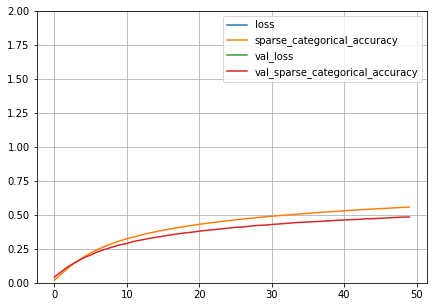

time: 157 ms (started: 2023-02-24 19:18:29 +00:00)


In [27]:
plot_loss(history)

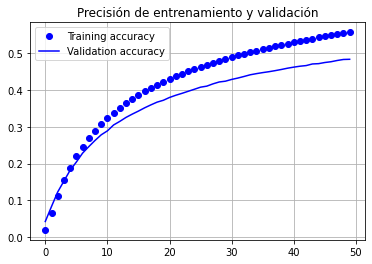

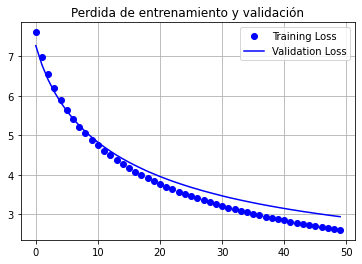

time: 237 ms (started: 2023-02-24 19:18:29 +00:00)


In [28]:
show_history(history)

In [29]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl9_imgs96_regular__OTSU.h5
time: 741 ms (started: 2023-02-24 19:18:29 +00:00)


# Imgs 112x112

- Test Accuracy: 0.644384503364563
- Test Loss: 1.7999496459960938
- time: 2h 29min 47s
- F1 score: 0.644348861342014
- Precision score: 0.6750918489111974
- Recall:  0.6443844856661045
- Epoch: 50/50




## Cargar imágenes

In [31]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_112/splits/regular_otsu/
time: 1.06 ms (started: 2023-02-24 19:21:40 +00:00)


In [32]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24.3 s (started: 2023-02-24 19:21:40 +00:00)


In [33]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.22 ms (started: 2023-02-24 19:22:04 +00:00)


## Preparar el modelo

In [34]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 1.63 s (started: 2023-02-24 19:22:04 +00:00)


In [35]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['concatenate_2[0][0]']    

## Entrenar modelo


In [36]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 184s 13ms/step - loss: 7.0580 - sparse_categorical_accuracy: 0.0358 - val_loss: 6.4380 - val_sparse_categorical_accuracy: 0.0772
Epoch 2/50
13899/13899 [==============================] - 178s 13ms/step - loss: 6.0076 - sparse_categorical_accuracy: 0.1236 - val_loss: 5.7227 - val_sparse_categorical_accuracy: 0.1507
Epoch 3/50
13899/13899 [==============================] - 179s 13ms/step - loss: 5.3798 - sparse_categorical_accuracy: 0.1959 - val_loss: 5.2230 - val_sparse_categorical_accuracy: 0.2079
Epoch 4/50
13899/13899 [==============================] - 179s 13ms/step - loss: 4.9162 - sparse_categorical_accuracy: 0.2540 - val_loss: 4.8410 - val_sparse_categorical_accuracy: 0.2513
Epoch 5/50
13899/13899 [==============================] - 179s 13ms/step - loss: 4.5489 - sparse_categorical_accuracy: 0.2996 - val_loss: 4.5332 - val_sparse_categorical_accuracy: 0.2872
Epoch 6/50
13899/13899 [==============================] - 179s 13

In [37]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.94 s (started: 2023-02-24 21:51:54 +00:00)


In [38]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 19s 10ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.644384503364563
- Test Loss: 1.7999496459960938
- time: 
- F1 score: 0.644348861342014
- Precision score: 0.6750918489111974
- Recall:  0.6443844856661045
- Epoch: 
*********************************************************************************************************************************
time: 41.7 s (started: 2023-02-24 21:51:58 +00:00)


## Graficando

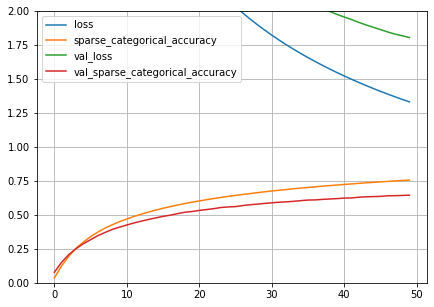

time: 166 ms (started: 2023-02-24 21:52:39 +00:00)


In [39]:
plot_loss(history)

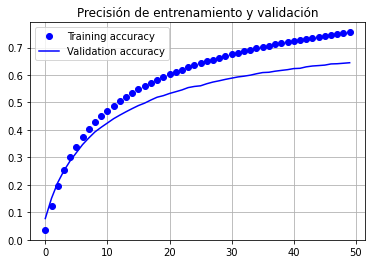

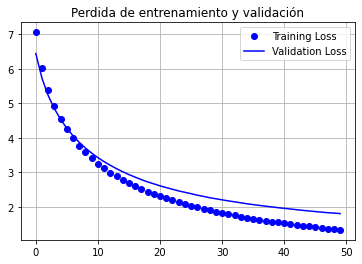

time: 248 ms (started: 2023-02-24 21:52:40 +00:00)


In [40]:
show_history(history)

In [41]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl9_imgs112_regular__OTSU.h5
time: 762 ms (started: 2023-02-24 21:52:40 +00:00)


# Imgs 127x127

- Test Accuracy: 0.5182124972343445
- Test Loss: 3.0383830070495605
- time: 2h 27min 51s
- F1 score: 0.5145795224618415
- Precision score: 0.5683398080983992
- Recall:  0.518212478920742
- Epoch: 50/50



## Cargar imágenes

In [42]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_otsu/
time: 751 µs (started: 2023-02-24 21:53:30 +00:00)


In [43]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 29.5 s (started: 2023-02-24 21:53:30 +00:00)


In [44]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.48 ms (started: 2023-02-24 21:54:00 +00:00)


## Preparar el modelo

In [45]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2 s (started: 2023-02-24 21:54:00 +00:00)


In [46]:
print(custom_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 127, 127, 3)  0           ['input_4[0][0]',                
                                                                  'input_4[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 133, 133, 3)  0           ['concatenate_3[0][0]']    

## Entrenar modelo

In [47]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 181s 13ms/step - loss: 7.7271 - sparse_categorical_accuracy: 0.0136 - val_loss: 7.4648 - val_sparse_categorical_accuracy: 0.0315
Epoch 2/50
13899/13899 [==============================] - 175s 13ms/step - loss: 7.2441 - sparse_categorical_accuracy: 0.0521 - val_loss: 7.0641 - val_sparse_categorical_accuracy: 0.0643
Epoch 3/50
13899/13899 [==============================] - 175s 13ms/step - loss: 6.8720 - sparse_categorical_accuracy: 0.0958 - val_loss: 6.7404 - val_sparse_categorical_accuracy: 0.1040
Epoch 4/50
13899/13899 [==============================] - 176s 13ms/step - loss: 6.5613 - sparse_categorical_accuracy: 0.1360 - val_loss: 6.4654 - val_sparse_categorical_accuracy: 0.1302
Epoch 5/50
13899/13899 [==============================] - 176s 13ms/step - loss: 6.2944 - sparse_categorical_accuracy: 0.1713 - val_loss: 6.2263 - val_sparse_categorical_accuracy: 0.1683
Epoch 6/50
13899/13899 [==============================] - 176s 13

## Graficando

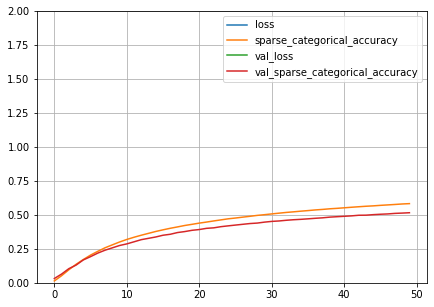

time: 145 ms (started: 2023-02-25 00:21:54 +00:00)


In [48]:
plot_loss(history)

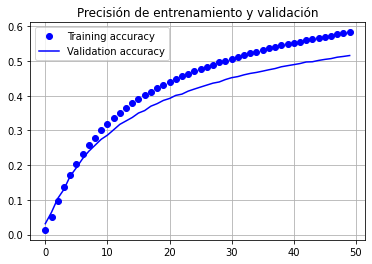

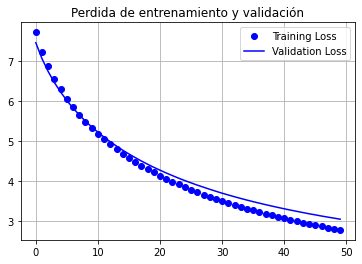

time: 242 ms (started: 2023-02-25 00:21:54 +00:00)


In [49]:
show_history(history)

In [50]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/ResNet50/weights_resnet50/sin_DA/regular/otsu_reg/model_resnet50_etl9_imgs127_regular__OTSU.h5
time: 738 ms (started: 2023-02-25 00:21:55 +00:00)


## Métricas

In [51]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 4.84 s (started: 2023-02-25 00:21:55 +00:00)


In [52]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 18s 9ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.5182124972343445
- Test Loss: 3.0383830070495605
- time: 
- F1 score: 0.5145795224618415
- Precision score: 0.5683398080983992
- Recall:  0.518212478920742
- Epoch: 
*********************************************************************************************************************************
time: 41.6 s (started: 2023-02-25 00:22:00 +00:00)


In [53]:
#runtime.unassign()

time: 266 µs (started: 2023-02-25 00:22:42 +00:00)
